In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kepmodel import rv, tools
from spleaf import term
from os import sys

sys.path.insert(0, '/Users/paula/Documents/school_of_summer/Copia-NWelch-main/src')
from TimeSeries import TimeSeries

plt.rcParams.update({'font.size':16, 'axes.labelsize':16})

### Read GJ 1002 timestamps, offset-corrected RV data, RV errors, and temperature-corrected FWHM

In [2]:
file = 'GJ1002_SuarezMascareno_2023.txt'
time, rvobs, rverr, fwhm = np.loadtxt(file, usecols=[0, 2, 5, 8], unpack=True, 
                                      skiprows=50, comments='#')


#usecols selecciona las columnas 

In [3]:
# Observation times are BJD-2450000
print(time[:10])

[7595.622 7596.621 7606.655 7610.647 7613.597 7617.599 7622.601 7625.564
 7626.587 7628.594]


### Planet periods from literature

In [4]:
pb = 10.3465 # period in days (looked up from exoplanet.eu)
pc = 20.202  # also from exoplanet.eu

### Plot the time series and the histogram of time stamps

You don't need to make these plots if you don't want to since you have already looked at them many times, but I need to refresh my memory

Nyquist frequency from mean dt: 0.03504
Nyquist frequency from 10% trimmed mean dt: 0.09190
Nyquist frequency from 20% trimmed mean dt: 0.11892
Nyquist frequency from median dt: 0.16714
Rayleigh resolution: 0.00051
Number of observations: 139


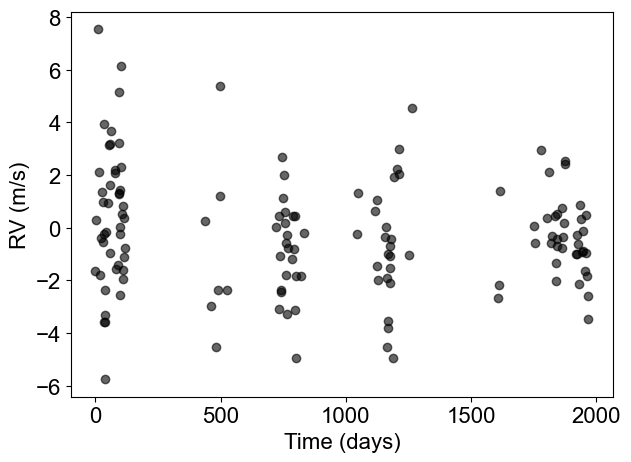

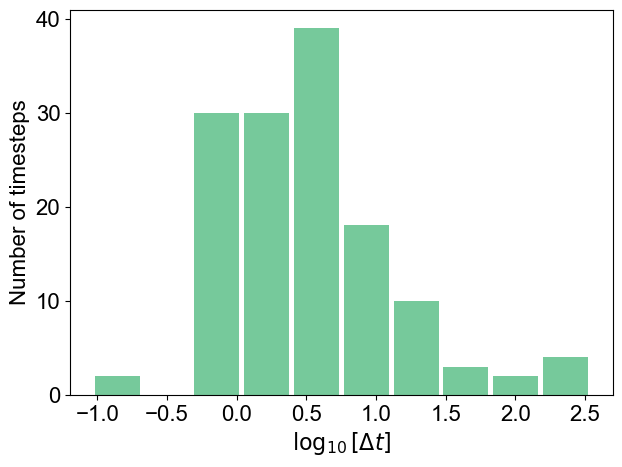

In [5]:
rv_ts = TimeSeries(time, rvobs)
rv_ts.scatterplot(xlabel='Time (days)', ylabel='RV (m/s)')
rv_ts.dthist()
print('Number of observations:', rv_ts.N)

### Estimate frequency of highest power

In [6]:
rv_ts.frequency_grid(0.16)
rv_ts.pow_FT()
fb_estimate_ind = np.argmax(rv_ts.power)
fb_estimate = rv_ts.powfgrid[fb_estimate_ind]
print('Estimated orbital frequency:', fb_estimate)
print('Estimated orbital period:', 1/fb_estimate)

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500
Estimated orbital frequency: 0.10095238095238093
Estimated orbital period: 9.905660377358492


In [7]:
#Error 
epb=(1/fb_estimate)-pb
print('diferencia', epb)
eppb=(((1/fb_estimate)-pb)/pb)*100
print('error porcentual', eppb)

diferencia -0.44083962264150856
error porcentual -4.260760862528474


#### Does Siegel's test suggest that the function is periodic?

In [8]:
rv_ts.Siegel_test() # Sensitive to one or two periodicities - conservative option
rv_ts.Siegel_test(tri=True) # Sensitive to up to three periodicities - more likely to be fooled by false positives

T statistic: 0.00328
T threshold for rejecting white noise hypothesis at 5% level: 0.00590
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
T statistic: 0.02387
T threshold for rejecting white noise hypothesis at 5% level: 0.02455
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)


#### No it does not!!

### Plot periodogram and mark frequency of highest power

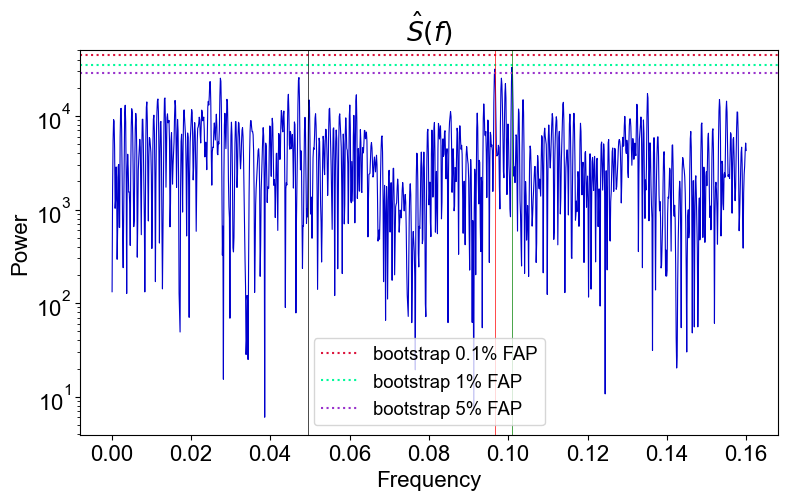

In [48]:
rv_ts.powplot()#vlines=[fb_estimate, 1/pb ])
plt.axvline(x=fb_estimate, color='green',lw=0.5)
plt.axvline(x=1/pb, color='red',lw=0.5)
plt.axvline(x=1/pc, color='black',lw=0.5)


### Function to phase-fold the observation times

In [10]:
# t: observation times
# p: period
phase_fold = lambda t, p: (t % p) / p

### Function for fitting Keplerian model to RV data

In [11]:
# Kepmodel fitting options
fit_method = 'L-BFGS-B'
fit_options = {'maxiter': 10000, 'maxcor': 500}

def add_planet_and_fit(model, period):
    model.add_keplerian_from_period(period)
    model.set_keplerian_param(f'{model.nkep-1}', param=['P', 'la0', 'K', 'ecosw', 'esinw'])
    model.fit(method=fit_method, options=fit_options)
    model.show_param()
    ll = model.loglike()
    print('log likelihood =', ll)
    return ll

### Define RvModel object and fit orbit of planet b

In [12]:
rv_model = rv.RvModel(time, rvobs, [], err = term.Error(rverr))
ll_b = add_planet_and_fit(rv_model, 1/fb_estimate)

Parameter                        Value     Error       
kep.0.P                       9.912698  ±  0.000556    
kep.0.la0 [deg]                  134.1  ±  19.0        
kep.0.K                          3.669  ±  0.503       
kep.0.ecosw                     0.7222  ±  0.0381      
kep.0.esinw                     0.2871  ±  0.0332      

log likelihood = -707.4447744743021


In [13]:
fitted_b_params = rv_model.get_param()
print(fitted_b_params)

[9.91269764 2.34085245 3.66868653 0.72220334 0.2870765 ]


In [42]:
#Error 
epb1=(9.912698)-pb
print('diferencia', epb)
eppb1=((9.912698-pb)/pb)*100
print('error porcentual', eppb)

diferencia -0.44083962264150856
error porcentual -4.260760862528474


### Create phased plot of the time series with the model of planet b

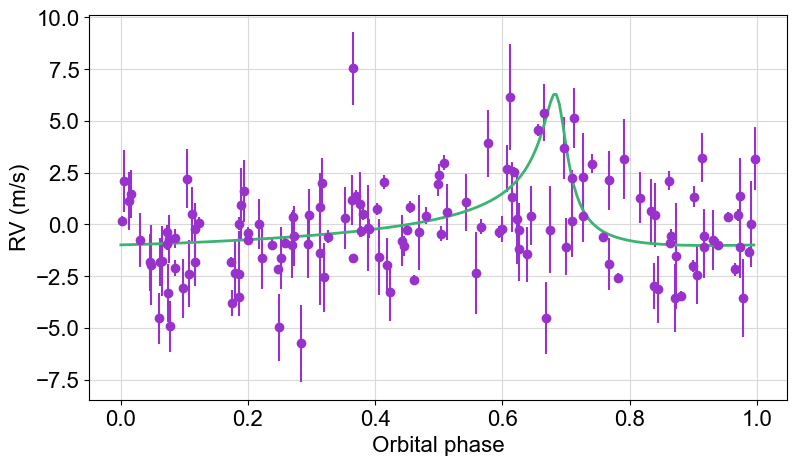

In [14]:
tt = np.linspace(np.min(time), np.max(time), num=301, endpoint=True)
predicted_rv = rv_model.keplerian_model(tt)

plt.figure(figsize=(9,5))
plt.errorbar(phase_fold(time, fitted_b_params[0]), rvobs, yerr=rverr, 
             color='darkorchid', marker='o', ls='')
phased_model = phase_fold(tt, fitted_b_params[0])
phase_sorted = np.argsort(phased_model)
plt.plot(phased_model[phase_sorted], predicted_rv[phase_sorted], color='mediumseagreen', lw=2)
plt.xlabel('Orbital phase')
plt.ylabel('RV (m/s)')
plt.grid(color='0.85')

This is an ugly model.

### Calculate residuals and plot their periodogram

See if we got rid of the power at the frequency of planet b

In [15]:
resids_b = rv_model.residuals()
rv_resid_ts = TimeSeries(time, resids_b)

Nyquist frequency from mean dt: 0.03504
Nyquist frequency from 10% trimmed mean dt: 0.09190
Nyquist frequency from 20% trimmed mean dt: 0.11892
Nyquist frequency from median dt: 0.16714
Rayleigh resolution: 0.00051


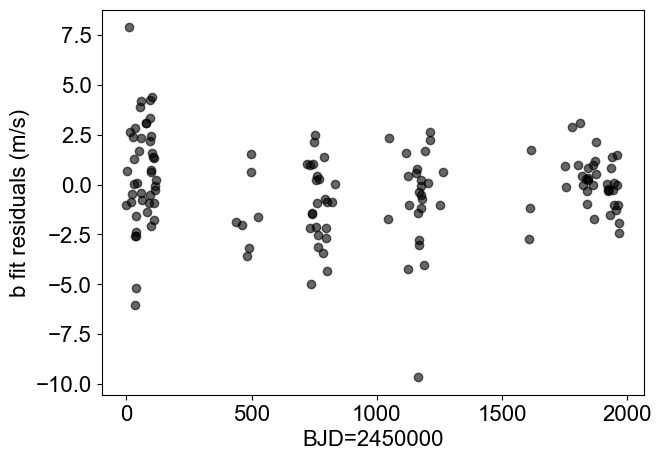

In [16]:
rv_resid_ts.scatterplot(xlabel='BJD=2450000', ylabel='b fit residuals (m/s)')

In [17]:
rv_resid_ts.frequency_grid(0.16)
rv_resid_ts.pow_FT()

Iteration 0


Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500


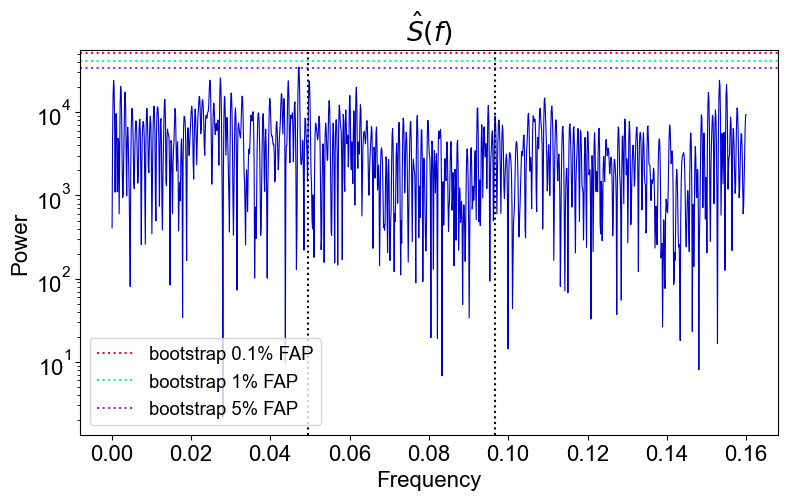

In [18]:
rv_resid_ts.powplot(vlines=[1/pb, 1/pc])

We got rid of the power at (near) the reported frequency of planet b. There is a slight peak in the residual periodogram near (not at) the frequency of planet c. However, it barely reaches the 5% statistical significance level.

### Use Siegel's test on the residuals from the fit to "planet b"

In [19]:
rv_resid_ts.Siegel_test()
rv_resid_ts.Siegel_test(tri=True)

T statistic: 0.00244
T threshold for rejecting white noise hypothesis at 5% level: 0.00590
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
T statistic: 0.02057
T threshold for rejecting white noise hypothesis at 5% level: 0.02455
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)


No periodic signal is detected in the residual!

### What if we use Welch's power spectrum estimator to search for planet b?

In [20]:
rv_ts.segment_data(2, 0.16, window='None')
rv_ts.Welch_powspec()
rv_ts.Welch_powspec_bootstrap()

Number of data points per segment: 92
Number of segments: 2
Segment start and end points: [[  0  92]
 [ 46 139]]
Effective number of segments: 1.600000
Frequency grid spacing: 0.000113
Minimum 6-dB main lobe half width: 0.000815
Mean 6-dB main lobe half width (1/2 resolution limit): 0.000920
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000673
Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500


(100, 200000.0)

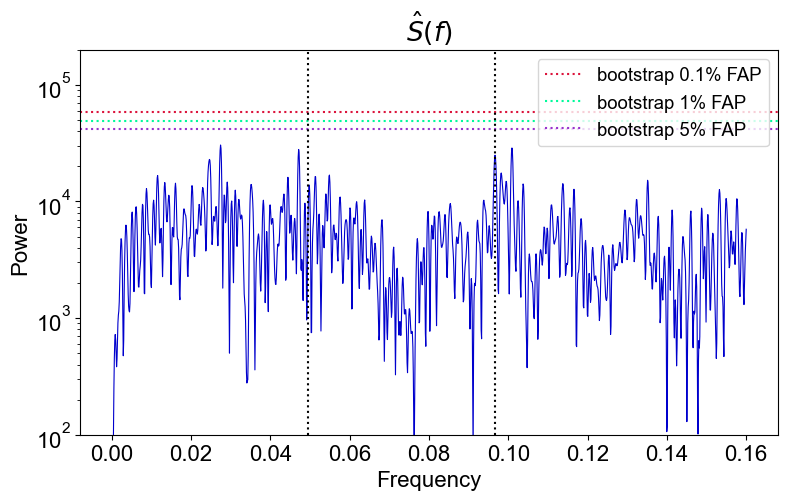

In [21]:
rv_ts.powplot(Welch=True, vlines=[1/pb, 1/pc])
plt.ylim([100,2e5])

### There is no significant power at the frequency of either planet b or planet c 

What frequency has the highest power?

In [22]:
highest_pow_ind = np.argmax(rv_ts.Welch_pow)
freq_highest_pow = rv_ts.Welch_powgrid[highest_pow_ind]

In [23]:
print(freq_highest_pow)

0.027454289732770754


### Siegel's test on the Welch's power spectrum estimate

In [24]:
rv_ts.Siegel_test(Welch=True)
rv_ts.Siegel_test(Welch=True, tri=True)

T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00540
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
T statistic: 0.00902
T threshold for rejecting white noise hypothesis at 5% level: 0.02307
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)


No signs of periodicity here either

#### See what happens if we fit a Keplerian model with that $f = 0.0275$ cycles/day as an initial guess

In [25]:
rv_model_2 = rv.RvModel(time, rvobs, [], err = term.Error(rverr))
ll_b_2 = add_planet_and_fit(rv_model_2, 1/freq_highest_pow)

Parameter                        Value     Error       
kep.0.P                       36.34147  ±  0.00404     
kep.0.la0 [deg]                  118.4  ±  11.2        
kep.0.K                          2.121  ±  0.198       
kep.0.ecosw                    -0.8413  ±  0.0172      
kep.0.esinw                    -0.0459  ±  0.0485      

log likelihood = -819.4331430357081


In [26]:
fitted_b_params_2 = rv_model_2.get_param()
print(fitted_b_params_2)

[36.34146871  2.06597968  2.12107367 -0.84134586 -0.04591816]


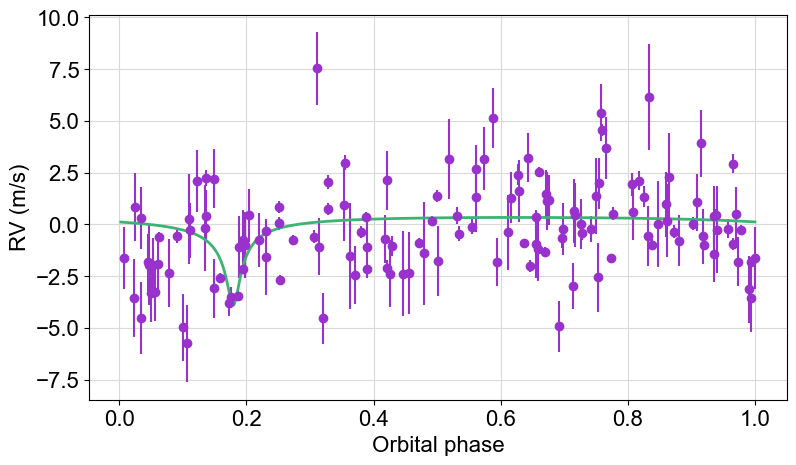

In [27]:
predicted_rv_2 = rv_model_2.keplerian_model(tt)

plt.figure(figsize=(9,5))
plt.errorbar(phase_fold(time, fitted_b_params_2[0]), rvobs, yerr=rverr, 
             color='darkorchid', marker='o', ls='')
phased_model_2 = phase_fold(tt, fitted_b_params_2[0])
phase_sorted_2 = np.argsort(phased_model_2)
plt.plot(phased_model_2[phase_sorted_2], predicted_rv_2[phase_sorted_2], color='mediumseagreen', lw=2)
plt.xlabel('Orbital phase')
plt.ylabel('RV (m/s)')
plt.grid(color='0.85')

Also a terrible model

### What about FWHM?

Nyquist frequency from mean dt: 0.03504
Nyquist frequency from 10% trimmed mean dt: 0.09190
Nyquist frequency from 20% trimmed mean dt: 0.11892
Nyquist frequency from median dt: 0.16714
Rayleigh resolution: 0.00051


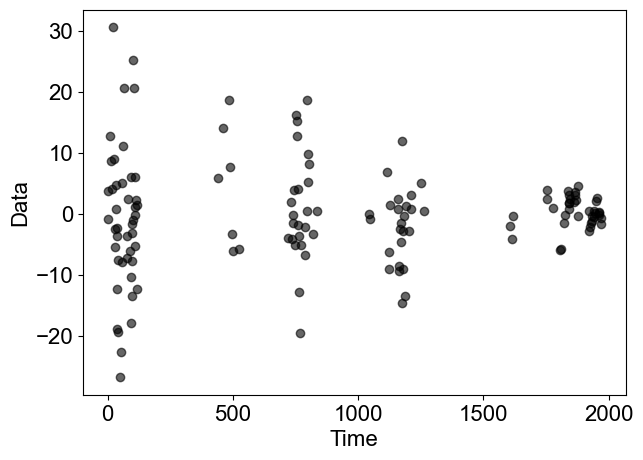

In [28]:
fwhm_ts = TimeSeries(time, fwhm)
fwhm_ts.scatterplot()

In [29]:
fwhm_ts.frequency_grid(0.16)
fwhm_ts.pow_FT()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500


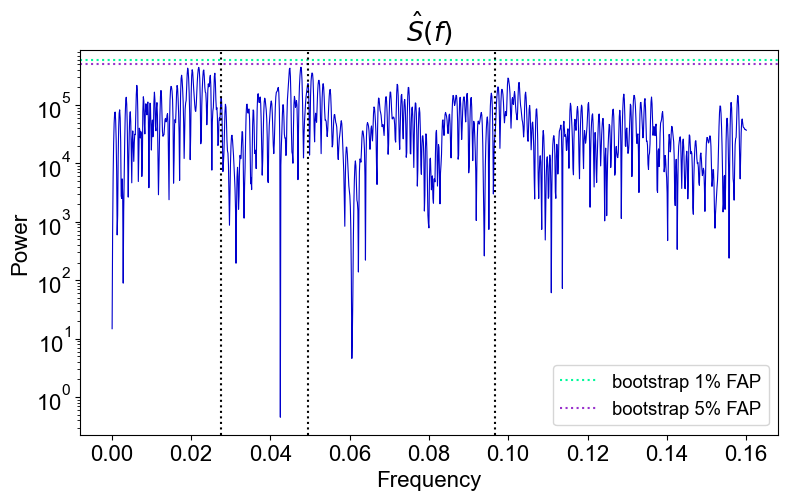

In [30]:
fwhm_ts.powplot(vlines=[0.0275, 1/pb, 1/pc])

In [31]:
fwhm_ts.Siegel_test()
fwhm_ts.Siegel_test(tri=True)

T statistic: 0.00467
T threshold for rejecting white noise hypothesis at 5% level: 0.00590
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
T statistic: 0.04287
T threshold for rejecting white noise hypothesis at 5% level: 0.02455
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


### This time series COULD be periodic

Likely signal(s): rotation, harmonics

### Welch's power spectrum and coherence with RV

In [32]:
from Bivariate import Bivariate

rv_fwhm = Bivariate(time, rvobs, fwhm)

Nyquist frequency from mean dt: 0.03504
Nyquist frequency from 10% trimmed mean dt: 0.09190
Nyquist frequency from 20% trimmed mean dt: 0.11892
Nyquist frequency from median dt: 0.16714
Rayleigh resolution: 0.00051


In [33]:
rv_fwhm.segment_data(2, 0.167)

Number of data points per segment: 92
Number of segments: 2
Segment start and end points: [[  0  92]
 [ 46 139]]
Effective number of segments: 1.600000
Frequency grid spacing: 0.000168
Minimum 6-dB main lobe half width: 0.000815
Mean 6-dB main lobe half width (1/2 resolution limit): 0.000920
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000673
Number of data points per segment: 92
Number of segments: 2
Segment start and end points: [[  0  92]
 [ 46 139]]
Effective number of segments: 1.600000
Frequency grid spacing: 0.000168
Minimum 6-dB main lobe half width: 0.000815
Mean 6-dB main lobe half width (1/2 resolution limit): 0.000920
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000673


In [34]:
rv_fwhm.Welch_coherence_powspec()
rv_fwhm.Welch_coherence_powspec_bootstrap()

Iteration 0


Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500

Mean number of false-alarm threshold crossings per Rayleigh resolution from bootstrap simulations:
5% FAP: 0.075
1% FAP: 0.005
0.1% FAP: 0.000

Number of false-alarm threshold crossings per Rayleigh resolution from actual data:
5% FAP: 0.089 crossings =  71.0350 %ile
1% FAP: 0.008 crossings =  69.2400 %ile
0.1% FAP: 0.000 crossings =  71.0350 %ile



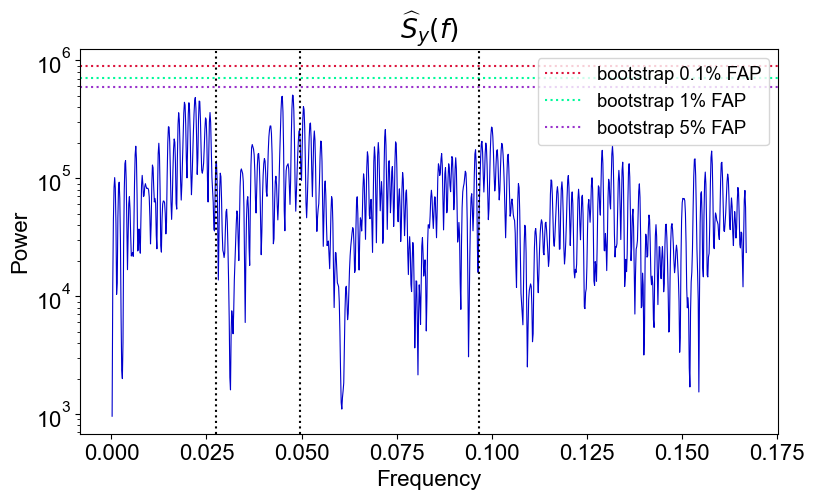

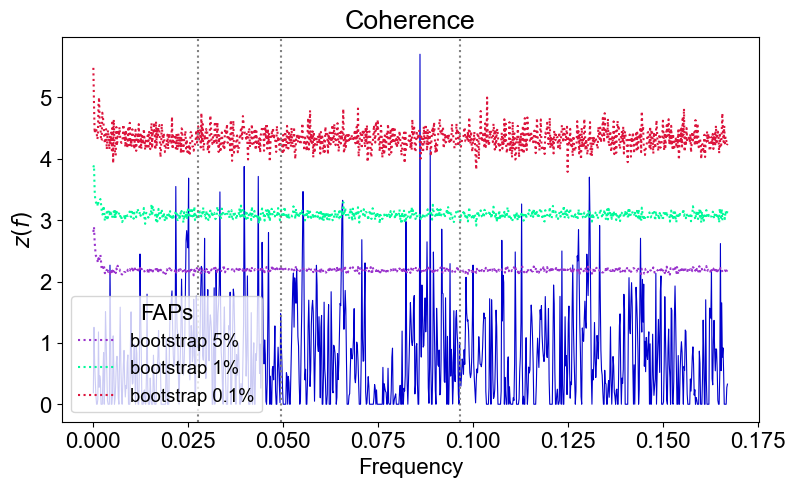

In [35]:
rv_fwhm.Welch_pow_plot(x_or_y='y', vlines=[0.0275, 1/pb, 1/pc])
rv_fwhm.coh_plot(transformed=True, vlines=[0.0275, 1/pb, 1/pc])

In [36]:
rv_fwhm.y_series.Siegel_test(Welch=True)
rv_fwhm.y_series.Siegel_test(Welch=True, tri=True)

T statistic: 0.00146
T threshold for rejecting white noise hypothesis at 5% level: 0.00701
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
T statistic: 0.03071
T threshold for rejecting white noise hypothesis at 5% level: 0.02778
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


In [37]:
max_Welch_fwhm_pow_ind = np.argmax(rv_fwhm.y_series.Welch_pow)
max_Welch_fwhm_pow = rv_fwhm.y_series.Welch_powgrid[max_Welch_fwhm_pow_ind]

In [38]:
print(max_Welch_fwhm_pow)

0.0476421370967742


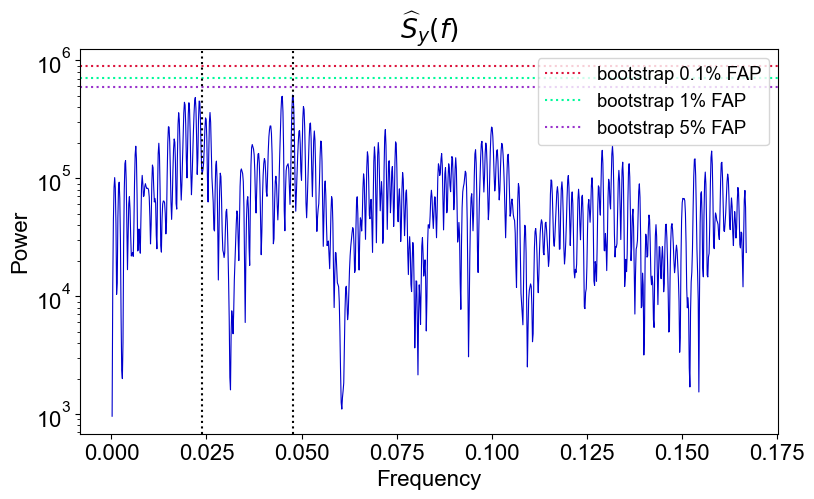

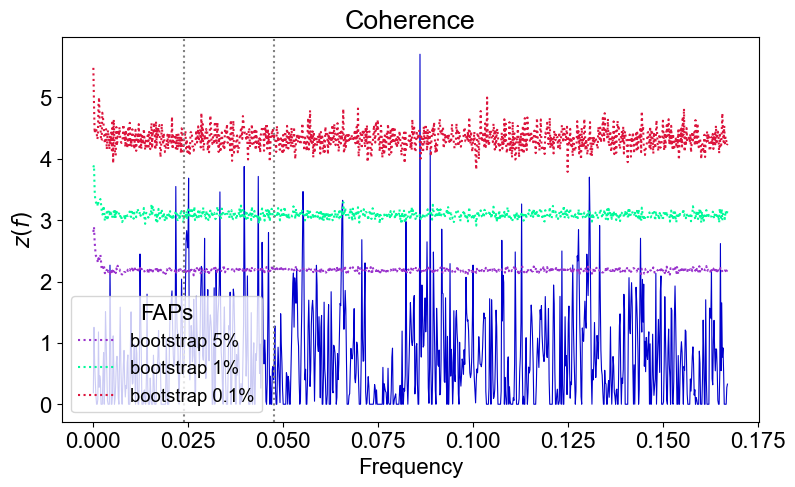

In [39]:
rv_fwhm.Welch_pow_plot(x_or_y='y', vlines=[max_Welch_fwhm_pow, max_Welch_fwhm_pow/2])
rv_fwhm.coh_plot(transformed=True, vlines=[max_Welch_fwhm_pow, max_Welch_fwhm_pow/2])

### Yes, I think we might have a rotation period and first harmonic

Or maybe just an ugly spectral window

Half bandwidth: 0.003030
Welch average spectral window not saved to file


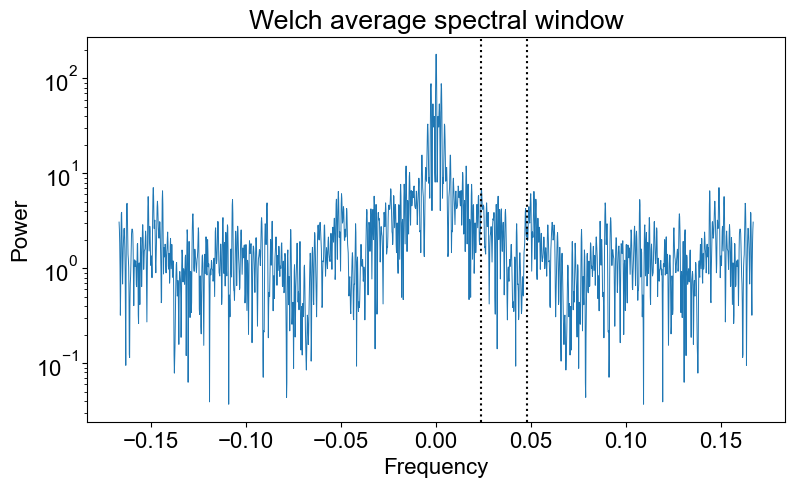

In [40]:
rv_fwhm.y_series.spectral_window_Welch()
plt.axvline(max_Welch_fwhm_pow, color='k', ls=':')
plt.axvline(max_Welch_fwhm_pow/2, color='k', ls=':')